## Dependencies

In [1]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [2]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS:  1


# Model parameters

In [4]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 64,
  "EPOCHS": 20,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'seresnet18',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 64,
 'EPOCHS': 20,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 5,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'BASE_MODEL': 'seresnet18',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [6]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotation = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    if p_spatial >= .2:
      if p_spatial >= .6: # Flips
        image['input_image'] = data_augment_spatial(image['input_image'])
      else: # Rotate
        image['input_image'] = data_augment_rotate(image['input_image'])

    if p_crop >= .6: # Crops
      image['input_image'] = data_augment_crop(image['input_image'])

    if p_spatial2 >= .5: 
      if p_spatial2 >= .75: # Shift
        image['input_image'] = data_augment_shift(image['input_image'])
      else: # Shear
        image['input_image'] = data_augment_shear(image['input_image'])
        
    if p_pixel >= .6: # Pixel-level transforms
      if p_pixel >= .9:
        image['input_image'] = data_augment_hue(image['input_image'])
      elif p_pixel >= .8:
        image['input_image'] = data_augment_saturation(image['input_image'])
      elif p_pixel >= .7:
        image['input_image'] = data_augment_contrast(image['input_image'])
      else:
        image['input_image'] = data_augment_brightness(image['input_image'])

    if p_rotation >= .5: # Rotation
      image['input_image'] = data_augment_rotation(image['input_image'])
    
    if p_cutout >= .5: # Cutout
      image['input_image'] = data_augment_cutout(image['input_image'])
    
    return image, label


def data_augment_rotation(image, max_angle=45.):
    image = transform_rotation(image, config['HEIGHT'], max_angle)
    return image

def data_augment_shift(image, h_shift=50., w_shift=50.):
    image = transform_shift(image, config['HEIGHT'], h_shift, w_shift)
    return image

def data_augment_shear(image, shear=25.):
    image = transform_shear(image, config['HEIGHT'], shear)
    return image

def data_augment_hue(image, max_delta=.02):
    image = tf.image.random_hue(image, max_delta)
    return image

def data_augment_saturation(image, lower=.8, upper=1.2):
    image = tf.image.random_saturation(image, lower, upper)
    return image

def data_augment_contrast(image, lower=.8, upper=1.2):
    image = tf.image.random_contrast(image, lower, upper)
    return image

def data_augment_brightness(image, max_delta=.1):
    image = tf.image.random_brightness(image, max_delta)
    return image

def data_augment_spatial(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)    
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_crop > .8:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
    elif p_crop > .6:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
    elif p_crop > .4:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    elif p_crop > .2:
        image = tf.image.central_crop(image, central_fraction=.8)
    else:
        image = tf.image.central_crop(image, central_fraction=.7)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(10, 10), max_mask_size=(80, 80)):
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [7]:
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

## Learning rate scheduler

In [8]:
lr_min = 1e-6
# lr_start = 0
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
# hold_max_steps = 0
# step_decay = .8
# step_size = steps_per_epoch * 1

# rng = [i for i in range(0, total_steps, 32)]
# y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
#                                warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
#                                lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

# sns.set(style="whitegrid")
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [10]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get(config['BASE_MODEL'])
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_WEIGHTS'], 
                           include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [11]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Resample dataframe
k_fold = k_fold[k_fold['image_name'].isin(image_names)]

# Test
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))

test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
#         tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint(model_path, monitor='val_auc', mode='max', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            optimizer = tfa.optimizers.RectifiedAdam(lr=lr_max,
                                                     total_steps=total_steps,
                                                     warmup_proportion=(warmup_steps / total_steps),
                                                     min_lr=lr_min)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch,
                            callbacks=[checkpoint, es],
                            class_weight=class_weight, 
                            verbose=2).history

        # save last epoch weights
        model.save_weights('last_' + model_path)

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Last model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds_last += model.predict(test_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Best model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds += model.predict(test_image_data)


# normalize preds
test_preds /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)


FOLD: 1
45359104/45351256 [==============================] - 1s 0us/step
Epoch 1/20
408/408 - 166s - loss: 0.8000 - auc: 0.7013 - val_loss: 0.1870 - val_auc: 0.5304
Epoch 2/20
408/408 - 164s - loss: 0.5376 - auc: 0.8306 - val_loss: 0.1760 - val_auc: 0.7721
Epoch 3/20
408/408 - 164s - loss: 0.5346 - auc: 0.8372 - val_loss: 0.3305 - val_auc: 0.8505
Epoch 4/20
408/408 - 167s - loss: 0.5306 - auc: 0.8414 - val_loss: 0.5611 - val_auc: 0.8179
Epoch 5/20
408/408 - 167s - loss: 0.5272 - auc: 0.8378 - val_loss: 1.0113 - val_auc: 0.7692
Epoch 6/20
408/408 - 163s - loss: 0.4862 - auc: 0.8613 - val_loss: 0.4893 - val_auc: 0.8784
Epoch 7/20
408/408 - 166s - loss: 0.4816 - auc: 0.8662 - val_loss: 0.4892 - val_auc: 0.8614
Epoch 8/20
408/408 - 165s - loss: 0.4658 - auc: 0.8718 - val_loss: 0.4501 - val_auc: 0.8768
Epoch 9/20
408/408 - 166s - loss: 0.4475 - auc: 0.8886 - val_loss: 0.4478 - val_auc: 0.8769
Epoch 10/20
408/408 - 158s - loss: 0.4462 - auc: 0.8902 - val_loss: 0.5515 - val_auc: 0.8004
Epoch

## Model loss graph

Fold: 1


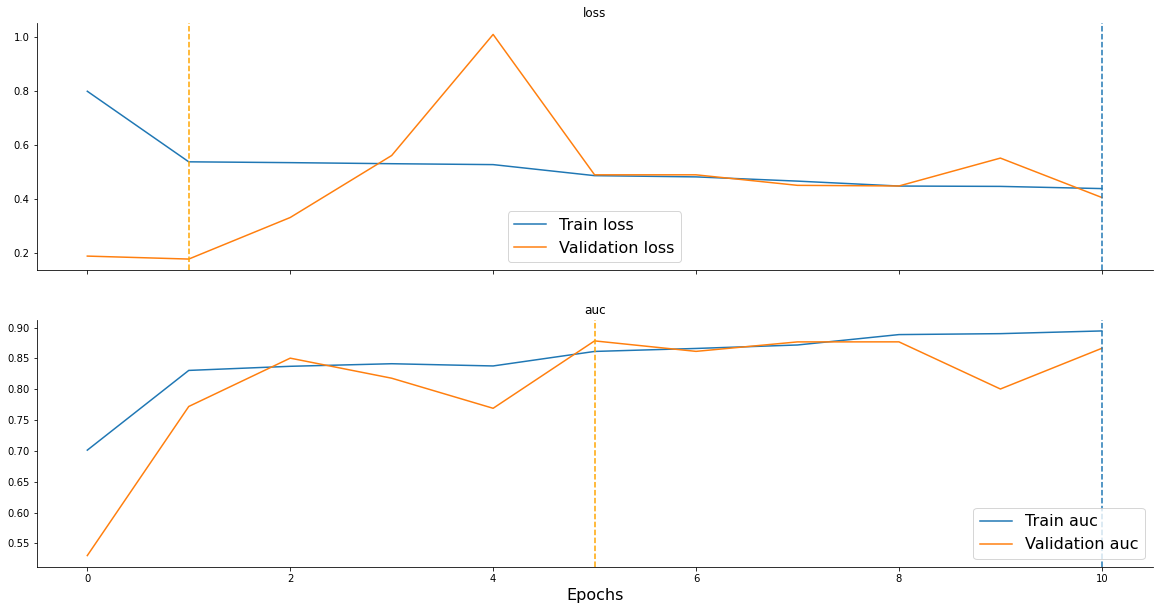

Fold: 2


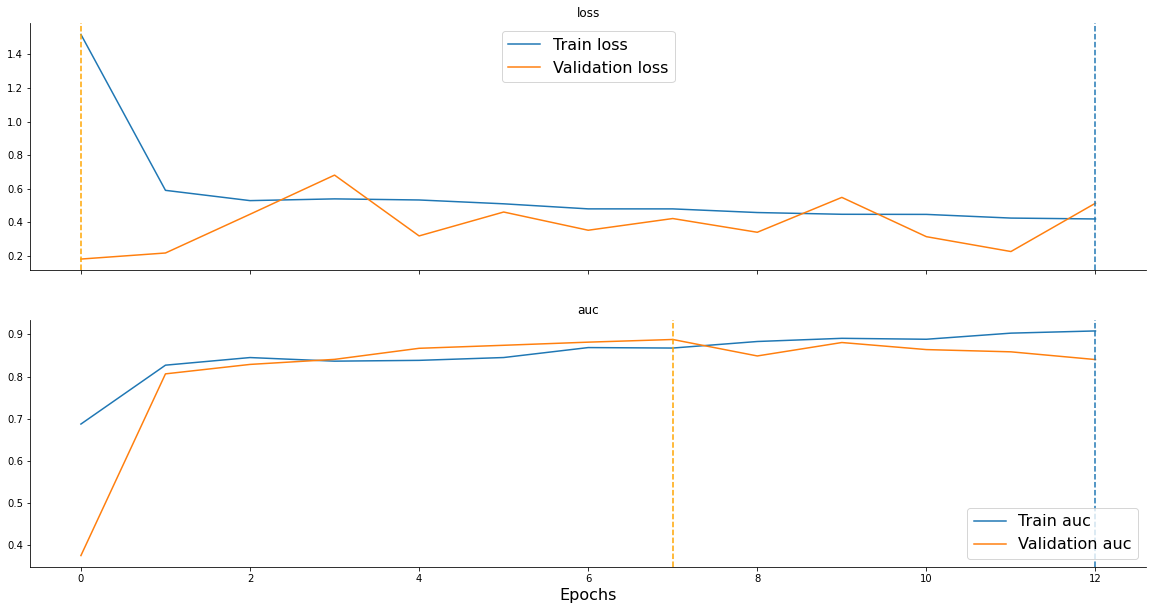

Fold: 3


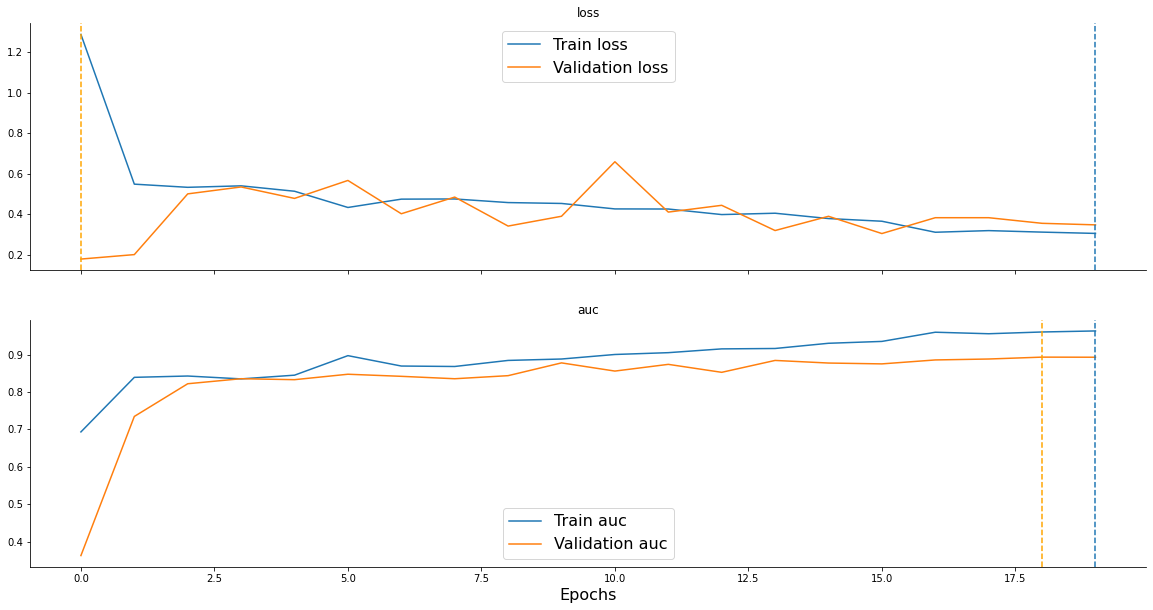

Fold: 4


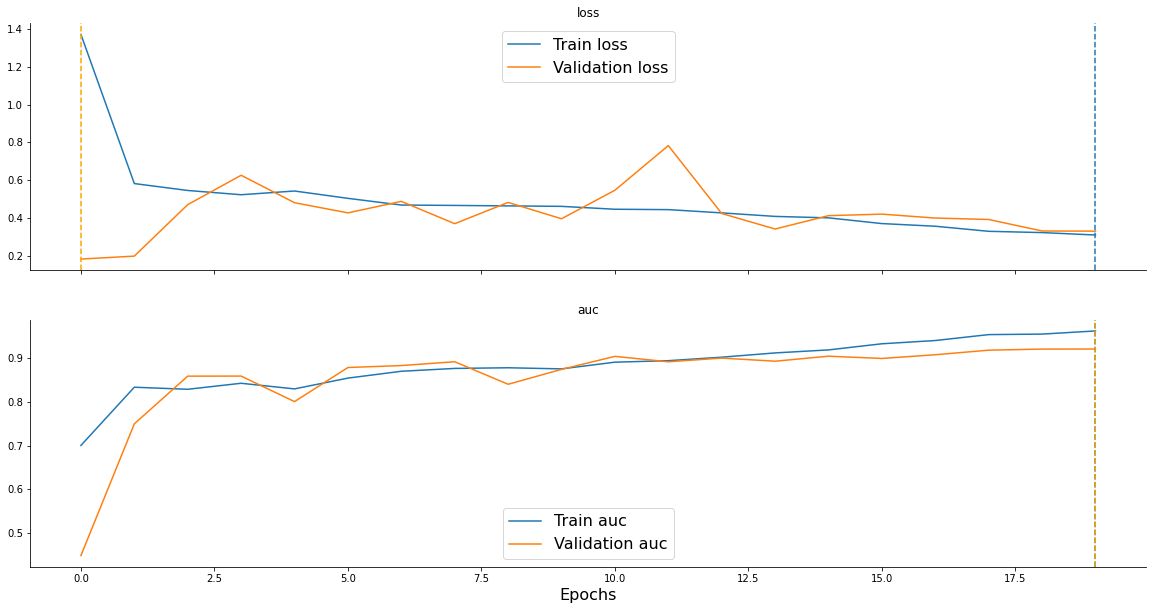

Fold: 5


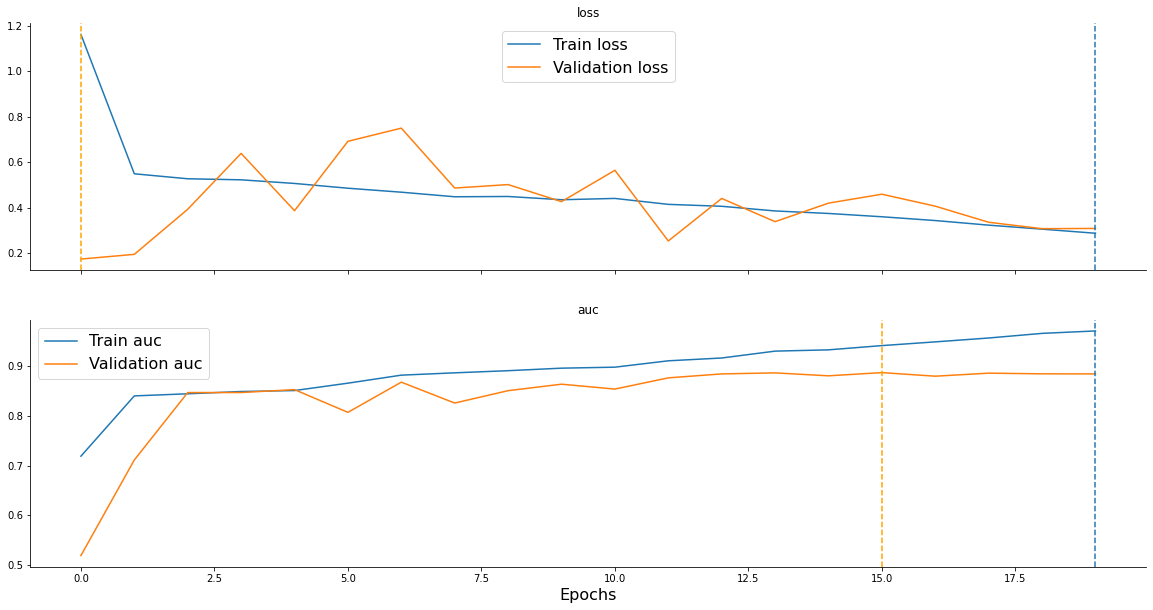

In [12]:
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

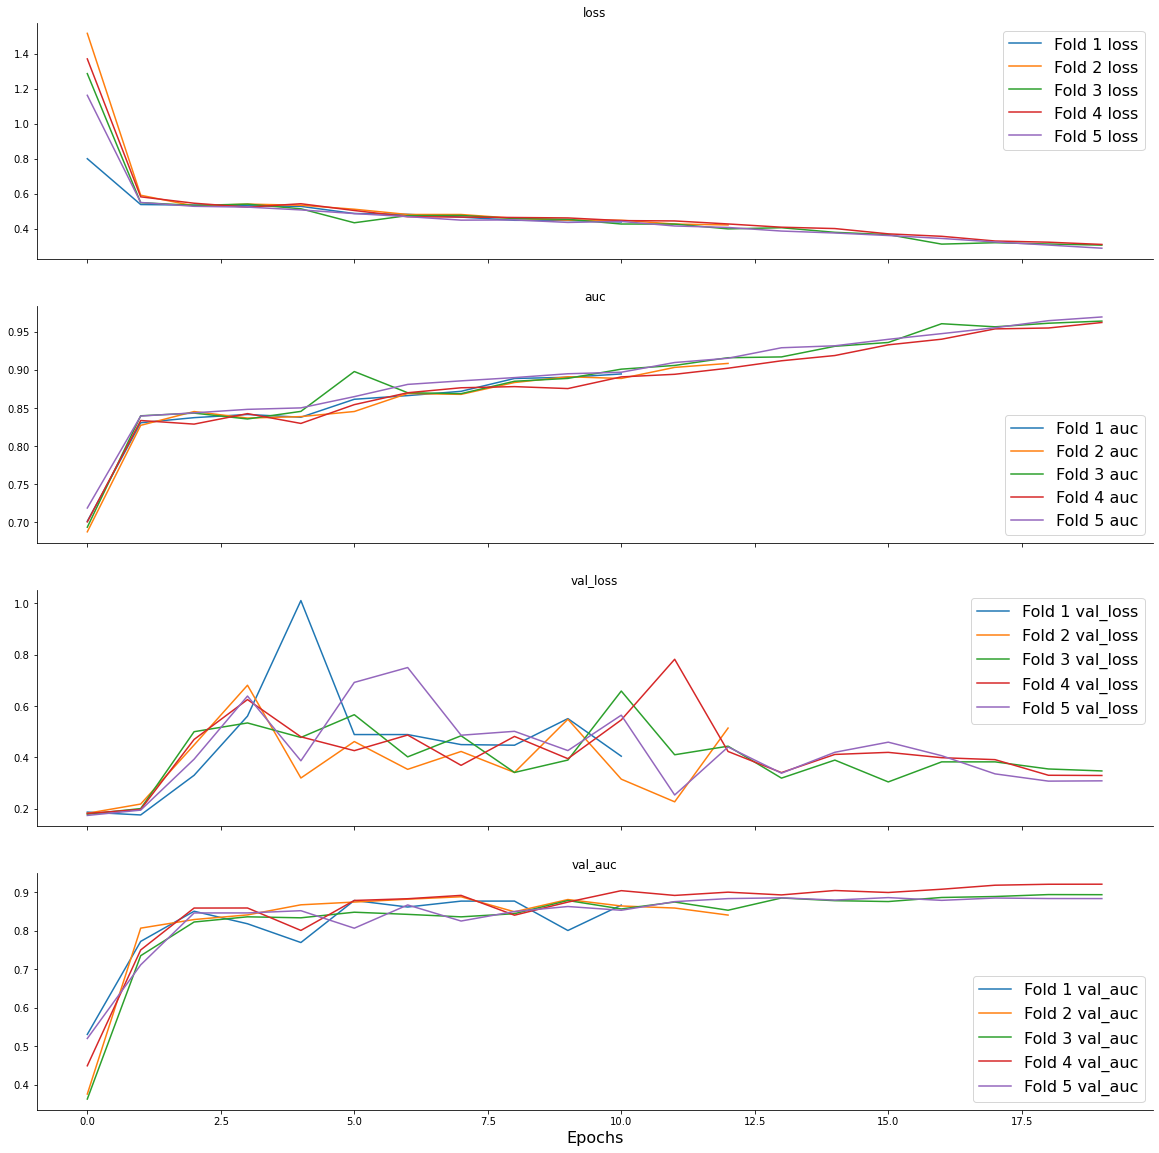

In [13]:
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (best)

In [14]:
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.949809,0.893800,0.056009,0.902429,0.880172,0.910314,0.888165,0.984769,0.894109,0.981579,0.920751,0.969952,0.885803
Accuracy,0.832417,0.826010,0.006406,0.765054,0.777115,0.815994,0.816536,0.886912,0.862811,0.891476,0.877985,0.802647,0.795604
Precision,0.098992,0.079797,0.019194,0.063087,0.062581,0.077655,0.072108,0.134604,0.089286,0.137363,0.106605,0.082250,0.068406
Recall,0.938521,0.793780,0.144741,0.879828,0.834783,0.860215,0.784483,0.989224,0.726496,0.971922,0.779661,0.991416,0.843478
F1-score,0.177950,0.144330,0.033620,0.117732,0.116434,0.142450,0.132075,0.236964,0.159027,0.240706,0.187564,0.151899,0.126549
Support,464.800000,116.200000,348.600000,466.000000,115.000000,465.000000,116.000000,464.000000,117.000000,463.000000,118.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.949809,0.893800,0.056009,0.902429,0.880172,0.910314,0.888165,0.984769,0.894109,0.981579,0.920751,0.969952,0.885803
male,0.949536,0.892167,0.057369,0.901891,0.880725,0.913067,0.870394,0.984248,0.887513,0.979582,0.925213,0.968892,0.896993
female,0.948455,0.891540,0.056915,0.900443,0.870869,0.903562,0.907930,0.984918,0.898334,0.983126,0.913508,0.970225,0.867058
head/neck,0.926334,0.856719,0.069615,0.890541,0.786673,0.852557,0.881194,0.969619,0.867456,0.968647,0.872101,0.950306,0.876173
upper extremity,0.951273,0.894320,0.056953,0.913182,0.885676,0.907112,0.871467,0.983693,0.924865,0.980571,0.923671,0.971807,0.865922
lower extremity,0.939445,0.870385,0.069060,0.860660,0.859228,0.889062,0.886580,0.987035,0.857591,0.984458,0.879535,0.976010,0.868991
torso,0.955730,0.908012,0.047719,0.916382,0.905046,0.925919,0.888408,0.986105,0.901926,0.981737,0.943565,0.968509,0.901113
0 <= age < 26,0.935675,0.844377,0.091298,0.887365,0.982507,0.887072,0.837876,0.978548,0.883067,0.982449,0.649160,0.942941,0.869277
26 <= age < 40,0.937875,0.842384,0.095491,0.857272,0.865759,0.896299,0.931474,0.983929,0.794153,0.984739,0.835996,0.967138,0.784540


# Model evaluation (last)

In [15]:
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.953344,0.881268,0.072075,0.904652,0.867301,0.910593,0.840661,0.984929,0.893838,0.981579,0.920751,0.984965,0.883791
Accuracy,0.855802,0.844963,0.010839,0.823017,0.826985,0.771138,0.757938,0.891733,0.867999,0.891476,0.877985,0.901649,0.893909
Precision,0.114272,0.086692,0.027579,0.077360,0.072391,0.065713,0.056970,0.139549,0.092593,0.137363,0.106605,0.151375,0.104905
Recall,0.931240,0.746779,0.184461,0.817597,0.747826,0.898925,0.810345,0.987069,0.726496,0.971922,0.779661,0.980687,0.669565
F1-score,0.202264,0.154333,0.047931,0.141347,0.132003,0.122473,0.106455,0.244527,0.164251,0.240706,0.187564,0.262267,0.181390
Support,464.800000,116.200000,348.600000,466.000000,115.000000,465.000000,116.000000,464.000000,117.000000,463.000000,118.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.953344,0.881268,0.072075,0.904652,0.867301,0.910593,0.840661,0.984929,0.893838,0.981579,0.920751,0.984965,0.883791
male,0.952678,0.883089,0.069589,0.905295,0.873590,0.910010,0.833958,0.984281,0.886853,0.979582,0.925213,0.984220,0.895831
female,0.952686,0.874870,0.077816,0.900890,0.851984,0.908751,0.846096,0.985282,0.898472,0.983126,0.913508,0.985381,0.864291
head/neck,0.919190,0.832713,0.086476,0.837809,0.748931,0.847371,0.776547,0.969507,0.868343,0.968647,0.872101,0.972614,0.897644
upper extremity,0.952030,0.875514,0.076516,0.906607,0.839132,0.902483,0.837471,0.983723,0.923969,0.980571,0.923671,0.986766,0.853327
lower extremity,0.954194,0.857456,0.096738,0.900621,0.864567,0.913345,0.811951,0.987446,0.857733,0.984458,0.879535,0.985098,0.873492
torso,0.957302,0.896679,0.060623,0.916761,0.889761,0.916595,0.853409,0.986259,0.901432,0.981737,0.943565,0.985159,0.895230
0 <= age < 26,0.936052,0.817853,0.118198,0.860325,0.976676,0.880857,0.727463,0.978737,0.884547,0.982449,0.649160,0.977889,0.851419
26 <= age < 40,0.946545,0.844030,0.102515,0.903337,0.855394,0.878830,0.897656,0.984189,0.788710,0.984739,0.835996,0.981630,0.842391


# Confusion matrix

Fold: 1


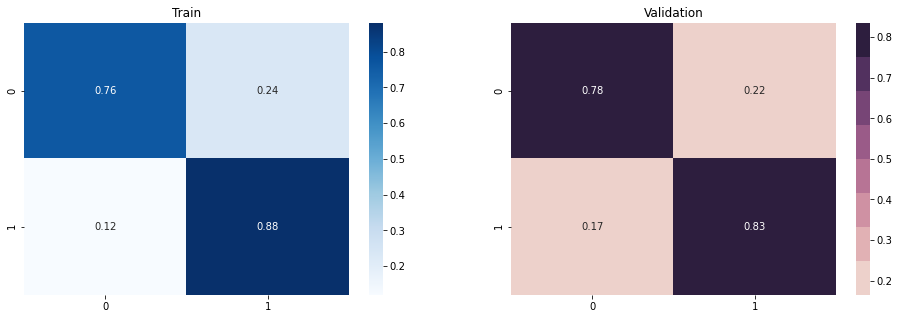

Fold: 2


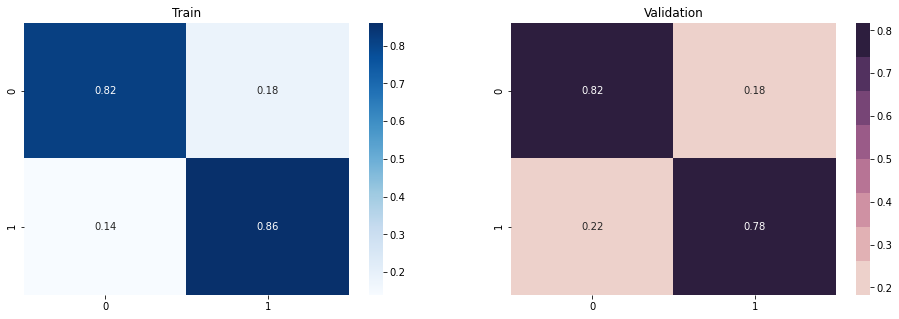

Fold: 3


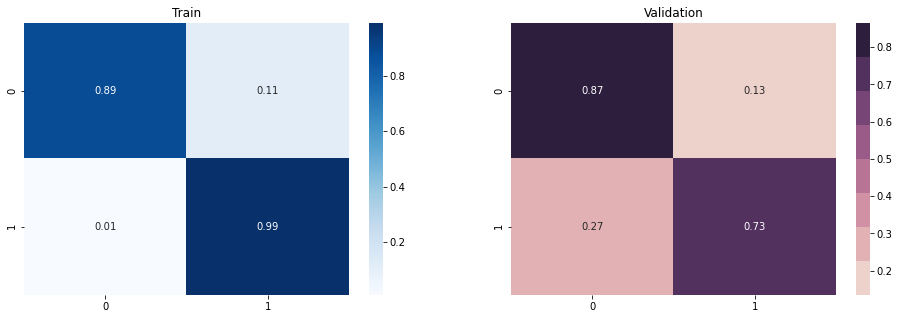

Fold: 4


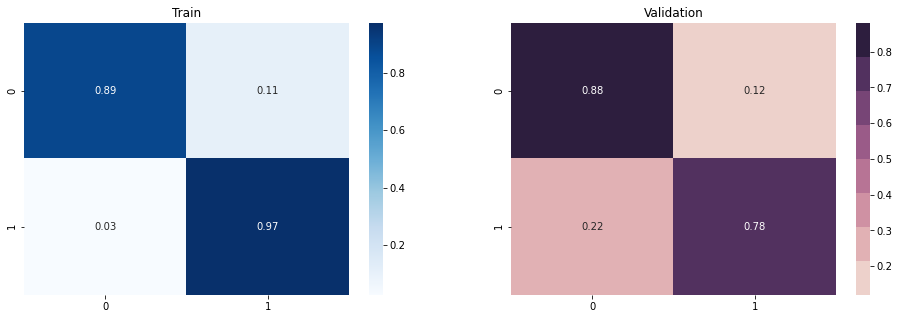

Fold: 5


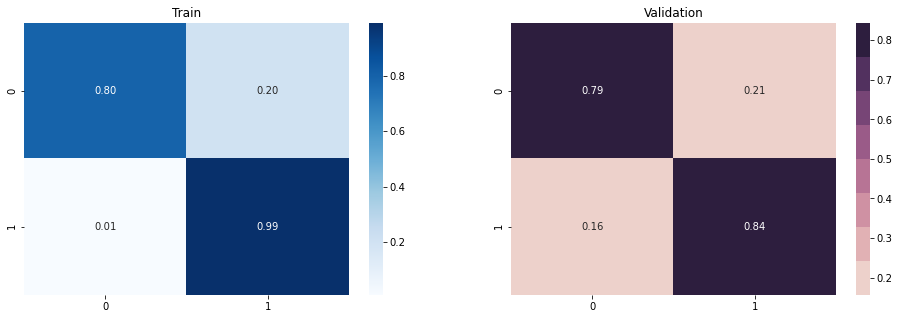

In [16]:
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [17]:
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 581
Train positive predictions: 4097
Train positive correct predictions: 563
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.187586,0.628948,0.241378,0.010098,0.016868,0.040641
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.013212,0.012014,0.025138,0.010539,0.010460,0.007910
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.016004,0.041789,0.011964,0.008502,0.005848,0.011917
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.145958,0.201881,0.206505,0.094584,0.146777,0.080042
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.060963,0.037040,0.234784,0.011446,0.012782,0.008762
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.027797,0.006615,0.073572,0.015448,0.027283,0.016067
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.183999,0.407068,0.408872,0.046393,0.029127,0.028537
7,ISIC_0075663,female,35.0,torso,unknown,0,0.138277,0.398933,0.089813,0.048326,0.081388,0.072923
8,ISIC_0075914,male,30.0,torso,unknown,0,0.026607,0.005054,0.037360,0.026939,0.030180,0.033501
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.067009,0.076694,0.030539,0.053813,0.128990,0.045007


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.641188,0.857123,0.855356,0.667031,0.814364,0.012063
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.907590,0.686364,0.978804,0.984577,0.967676,0.920531
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.812824,0.740678,0.748617,0.949136,0.680945,0.944743
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.692640,0.772221,0.132028,0.884271,0.752901,0.921778
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.739452,0.756096,0.951419,0.033110,0.980057,0.976578
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.916670,0.893719,0.855902,0.906210,0.945433,0.982087
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.682976,0.417497,0.112107,0.971801,0.974204,0.939270
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.713728,0.509038,0.689121,0.958758,0.913757,0.497964
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.766261,0.454400,0.833019,0.804377,0.926510,0.813000
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.885539,0.732710,0.958593,0.843436,0.919496,0.973462


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
10,ISIC_0076545,male,55.0,upper extremity,unknown,0,0.816946,0.762686,0.778251,0.785613,0.802684,0.955494
20,ISIC_0080817,male,50.0,lower extremity,unknown,0,0.513556,0.536699,0.580621,0.402502,0.596097,0.451860
78,ISIC_0125706,female,60.0,torso,unknown,0,0.619672,0.832953,0.850065,0.602795,0.188496,0.624052
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.641188,0.857123,0.855356,0.667031,0.814364,0.012063
95,ISIC_0150975,female,50.0,lower extremity,unknown,0,0.567700,0.415780,0.096926,0.862435,0.778148,0.685209
100,ISIC_0153549,female,45.0,lower extremity,unknown,0,0.547945,0.710039,0.613571,0.383435,0.290203,0.742474
111,ISIC_0155012,male,55.0,torso,nevus,0,0.568851,0.345201,0.594481,0.682585,0.534840,0.687147
116,ISIC_0156460,female,35.0,torso,unknown,0,0.628582,0.327416,0.859717,0.667383,0.735844,0.552548
123,ISIC_0159060,male,55.0,head/neck,unknown,0,0.886674,0.912830,0.972428,0.950246,0.889422,0.708444
128,ISIC_0159996,female,60.0,head/neck,unknown,0,0.663279,0.809358,0.914258,0.569563,0.400721,0.622496


# Visualize test predictions

In [18]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 2263|8719
Test predictions (last) 1781|9201
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
0,ISIC_0052060,male,70.0,NaN,0.068897,0.067208
1,ISIC_0052349,male,40.0,lower extremity,0.014186,0.006326
2,ISIC_0058510,female,55.0,torso,0.018019,0.018362
3,ISIC_0073313,female,50.0,torso,0.019286,0.011909
4,ISIC_0073502,female,45.0,lower extremity,0.441128,0.353724
5,ISIC_0074618,male,50.0,lower extremity,0.409274,0.133751
6,ISIC_0076801,male,45.0,upper extremity,0.091648,0.021605
7,ISIC_0077586,male,50.0,lower extremity,0.464372,0.272459
8,ISIC_0082004,female,45.0,torso,0.309352,0.187282
9,ISIC_0082785,male,65.0,lower extremity,0.127832,0.099474


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
19,ISIC_0099348,female,45.0,upper extremity,0.571514,0.548989
24,ISIC_0112420,female,65.0,torso,0.903936,0.869310
41,ISIC_0155813,male,55.0,lower extremity,0.620046,0.565702
42,ISIC_0155983,male,70.0,torso,0.909533,0.932116
45,ISIC_0161963,male,35.0,upper extremity,0.586330,0.484618
56,ISIC_0169906,male,85.0,torso,0.776954,0.718993
57,ISIC_0171865,male,65.0,palms/soles,0.721040,0.644715
61,ISIC_0175798,female,55.0,torso,0.890754,0.837666
64,ISIC_0178235,female,70.0,lower extremity,0.786230,0.713065
69,ISIC_0182213,female,80.0,head/neck,0.595829,0.686891


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
19,ISIC_0099348,female,45.0,upper extremity,0.571514,0.548989
22,ISIC_0105104,male,40.0,torso,0.341583,0.508635
24,ISIC_0112420,female,65.0,torso,0.903936,0.869310
41,ISIC_0155813,male,55.0,lower extremity,0.620046,0.565702
42,ISIC_0155983,male,70.0,torso,0.909533,0.932116
56,ISIC_0169906,male,85.0,torso,0.776954,0.718993
57,ISIC_0171865,male,65.0,palms/soles,0.721040,0.644715
61,ISIC_0175798,female,55.0,torso,0.890754,0.837666
64,ISIC_0178235,female,70.0,lower extremity,0.786230,0.713065
69,ISIC_0182213,female,80.0,head/neck,0.595829,0.686891


# Test set predictions

In [19]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv('submission.csv', index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv('submission_last.csv', index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv('submission_blend.csv', index=False)

,image_name,target,target_last,target_blend
0,ISIC_0052060,0.068897,0.067208,0.068052
1,ISIC_0052349,0.014186,0.006326,0.010256
2,ISIC_0058510,0.018019,0.018362,0.018190
3,ISIC_0073313,0.019286,0.011909,0.015597
4,ISIC_0073502,0.441128,0.353724,0.397426
5,ISIC_0074618,0.409274,0.133751,0.271512
6,ISIC_0076801,0.091648,0.021605,0.056626
7,ISIC_0077586,0.464372,0.272459,0.368416
8,ISIC_0082004,0.309352,0.187282,0.248317
9,ISIC_0082785,0.127832,0.099474,0.113653


,target,target_last,target_blend
count,10982.000000,10982.000000,10982.000000
mean,0.260842,0.234705,0.247774
std,0.258730,0.238898,0.245975
min,0.005414,0.002692,0.004782
25%,0.035876,0.032852,0.037094
50%,0.161473,0.150221,0.159043
75%,0.435745,0.366464,0.397803
max,0.960734,0.975874,0.963968
